<a href="https://colab.research.google.com/github/ARMargolis/melanoma-pytorch/blob/master/flowers_pytorch_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [3]:
# If this code gives an error, open a flower notebook and run 
# from kaggle_datasets import KaggleDatasets
# GCS_DS_PATH = KaggleDatasets().get_gcs_path() # you can list the bucket with "!gsutil ls $GCS_DS_PATH"
# print(GCS_DS_PATH)
GCS_DS_PATH =r'gs://kds-752f9da513db142ac27a6ea4f8367cf796b314d58c3786ab37bec03a'

IMAGE_SIZE = [512, 512] # At this size, a GPU will run out of memory. Use the TPU.
                        # For GPU training, please select 224 x 224 px image size.
EPOCHS = 12
BATCH_SIZE = 16 #Using GPU
#BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
#TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

In [4]:
import re, numpy as np

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames) # automatically interleaves reads from multiple files
    #dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord)
    #dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment)
    #dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048, seed=42)
    dataset = dataset.batch(BATCH_SIZE)
    #dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    #dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    #dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
#NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
#STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))

Dataset: 12753 training images, 3712 validation images


In [5]:
import pandas as pd
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
import pandas as pd 
import numpy as np
import torch
from torch import nn, sigmoid
from torch.nn import functional as F
from torch.utils import data
from torch.optim import Adam

from PIL import Image, ImageOps
from torchvision import transforms, utils

default_device = 'cuda' if torch.cuda.is_available() else 'cpu'

class flowerDataSet(data.Dataset):
    # TODO initialize conv layers and fc layers in a particular way. Important for our experiment
    # TODO add cuda support
    
    def __init__(self, gcs_path, train, device = default_device, transform=None):
        """
        Initializes the dataset. Will use .tfrec files
        gcs_path (str): GCS path where images and labels are stored
        specifications (optional): any extra keyword args are stored in a dict. Can include:
            -transform
            -resolution: what size do we want to resize the images to? Square or rectangular?
        """
        
        self.train=train
        if transform:
          self.transform=transform
        else:
          self.transform=transforms.ToTensor()

        self.gcs_path = gcs_path
        tfrec_dataset = tf.data.TFRecordDataset(gcs_path)
        tfrec_dataset_cache=tfrec_dataset.cache()
        if self.train:
          tfrec_dataset_cache_map1=tfrec_dataset_cache.map(read_labeled_tfrecord)
        else:
          tfrec_dataset_cache_map1=tfrec_dataset_cache.map(read_unlabeled_tfrecord)
        self.data_iter=tfrec_dataset_cache_map1.as_numpy_iterator()
        self.label_df=pd.Series(tf.io.gfile.glob(gcs_path))

        self.device = device
    
    def __len__(self):
        return self.label_df.shape[0]

    def __getitem__(self, idx):
        """
            Get a single sample
            Want this method to be very fast, i.e. few or no if statements, etc.
        """
        #if torch.is_tensor(idx):
        #    idx = idx.tolist()
        
        next_data=next(self.data_iter)
        img=self.transform(Image.fromarray((next_data[0]* 255).astype(np.uint8)))
        return img, torch.tensor(next_data[1], dtype=torch.long)

        # get PIL image
        #decoded_img=decode_image(next_data[0])
        #decoded_img=decode_image(next_data[0].astype(np.uint8)).numpy().astype(np.uint8)
        #image = Image.fromarray(decoded_img)
        #image = self.transform(image)
        #image = image.to(self.device)

        #if self.train: #Include the label if it's training data
          #label=next_data[1]
          #return (image, torch.LongTensor([label]))
        #return (image, next_data[1])

    def display_sample(self, idx):
        pic, label = self.__getitem__(idx)
        #pic = pic.to('cpu')
        pic = transforms.functional.to_pil_image(pic)
        print(CLASSES[label])
        # if not using in jupyter notebook context, show the image directly instead of returning it
        # pic.show()
        return pic

In [6]:
transform=transforms.Compose(
                    [
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomRotation(degrees=45, resample = Image.BICUBIC, expand = True),
                        transforms.RandomCrop((224,224)),
                        transforms.ToTensor()
                    ])
IMAGE_SIZE=[512,512]
train_data = flowerDataSet(gcs_path=TRAINING_FILENAMES, train = True, transform=transform)

snapdragon


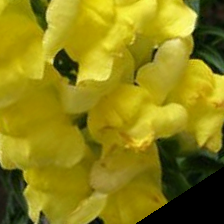

In [ ]:
train_data.display_sample(0)

In [ ]:
import torchvision.models as models
model = models.resnet18(pretrained = True)

In [ ]:
# Freeze the parameters 
for param in model.parameters():
    param.requires_grad = False 

In [ ]:
from collections import OrderedDict

#Classifier architecture to put on top of resnet18
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,104)),
    #('relu', nn.ReLU()),
    #('fc2', nn.Linear(100,104)),
    ('output', nn.LogSoftmax(dim=1))
]))

model.fc = fc

model.to(default_device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
from torch import nn
from torch import optim
from time import ctime
import matplotlib.pyplot as plt
from torchvision import transforms

#function to train the model
def train_validate(model, train_names, val_names, criterion, optimizer, epochs = 5, BATCH_SIZE=8,
                   t_transform=None, v_transform=None):
    print('Begin', ctime())
    for e in range(epochs):
      train_data = flowerDataSet(gcs_path=train_names, train = True, transform=t_transform)
      trainloader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle=False)
      train_loss =[]
      val_loss=[]
      running_loss=0
      batch_num=0
      for s in range(NUM_TRAINING_IMAGES//BATCH_SIZE):
        for images, labels in trainloader:
            inputs, labels = images.to(default_device), labels.to(default_device)
            batch_num+=1

            optimizer.zero_grad()
            img = model(inputs)
            loss = criterion(img, labels)
            running_loss+=loss.item()
            loss.backward()
            optimizer.step()
      train_loss.append(running_loss/NUM_TRAINING_IMAGES)
      print('Training Steps:', NUM_TRAINING_IMAGES//BATCH_SIZE, "Batches:", batch_num)
      running_loss=0
      batch_num=0
      val_data = flowerDataSet(gcs_path=val_names, train = True, transform=v_transform)
      val_loader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle=False)
      for s in range(NUM_VALIDATION_IMAGES//BATCH_SIZE):
          for images, labels in val_loader:
            inputs, labels = images.to(default_device), labels.to(default_device)
            batch_num+=1

            img = model(inputs)
            loss = criterion(img, labels)
            running_loss+=loss.item()

      val_loss.append(running_loss/NUM_VALIDATION_IMAGES)
      print('Validation Steps:', NUM_VALIDATION_IMAGES//BATCH_SIZE, "Batches:", batch_num)
      print("Epoch : {}/{}..".format(e+1,epochs),
         "Training Loss:", train_loss[-1],
         "Validation Loss:", val_loss[-1], ctime()) 
      torch.save(model.state_dict(), '/content/gdrive/My Drive/flowers0822_e{:02d}.pth'.format(e))

    plt.plot(train_loss,label="Training Loss")
    plt.plot(val_loss,label="Validation Loss")
    plt.show() 
    
  

In [8]:
epochs = 5
#optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.NLLLoss()
t_transform=transforms.Compose([
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomRotation(degrees=45, resample = Image.BICUBIC, expand = True),
                        transforms.RandomCrop((224,224)),
                        transforms.ToTensor()])
v_transform=transforms.Compose(
                    [
                        transforms.Resize((224,224)),
                        transforms.ToTensor()
                    ])

#train_validate(model,TRAINING_FILENAMES, VALIDATION_FILENAMES, criterion, optimizer, epochs,
#               t_transform=t_transform, v_transform=v_transform) 

In [ ]:
list(model.modules())

[ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

In [9]:
import torch.nn.utils.prune as prune

def prune_network(model, proportion):
    for module in list(model.children()):
        if isinstance(module,nn.Conv2d) or isinstance(module, nn.Conv1d):
            # conv layer? -> Structured pruning of channels? or unstructured?
            # Below is prune based on l2 norm, by channel
            prune.ln_structured(module, name="weight", amount=proportion, n=2, dim=0)
            # For just unstructured pruning, uncomment the line below:
            #prune.l1_unstructured(module, "weight", proportion)
        elif isinstance(module,nn.Linear):
            # fc layer? -> prune all weights, unstructured
            prune.l1_unstructured(module, "weight", proportion)

PRUNING ITERATION  0 Prune proportion: 0.1 Sun Aug 23 10:20:24 2020
---------------------
PRUNING ITERATION  0 Sun Aug 23 10:20:24 2020
Begin Sun Aug 23 10:20:24 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.23394182081139528 Validation Loss: 0.18275157917001894 Sun Aug 23 10:34:36 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.2105377683927057 Validation Loss: 0.17536686977837235 Sun Aug 23 10:45:13 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.20112733456220644 Validation Loss: 0.17006172005344053 Sun Aug 23 10:55:50 2020


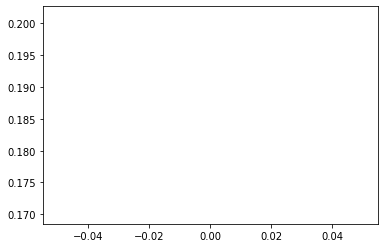

pruning network...
PRUNING ITERATION  1 Prune proportion: 0.19 Sun Aug 23 10:55:52 2020
---------------------
PRUNING ITERATION  1 Sun Aug 23 10:55:52 2020
Begin Sun Aug 23 10:55:52 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.23092209321489 Validation Loss: 0.18267425668730947 Sun Aug 23 11:06:33 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.20924909616987966 Validation Loss: 0.17312881889640644 Sun Aug 23 11:17:09 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.20109774282490292 Validation Loss: 0.1684672992198792 Sun Aug 23 11:27:32 2020


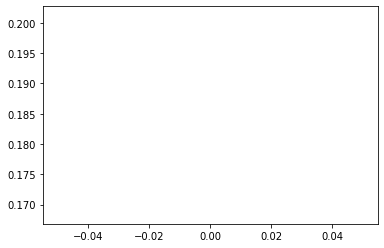

pruning network...
PRUNING ITERATION  2 Prune proportion: 0.271 Sun Aug 23 11:27:33 2020
---------------------
PRUNING ITERATION  2 Sun Aug 23 11:27:33 2020
Begin Sun Aug 23 11:27:33 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/4.. Training Loss: 0.2405528436382546 Validation Loss: 0.186005522942588 Sun Aug 23 11:37:55 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/4.. Training Loss: 0.2119409956553866 Validation Loss: 0.1792342469722418 Sun Aug 23 11:48:15 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/4.. Training Loss: 0.20126269227157412 Validation Loss: 0.17166797400869685 Sun Aug 23 11:58:32 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 4/4.. Training Loss: 0.1945839225626605 Validation Loss: 0.1690524776992067 Sun Aug 23 12:08:54 2020


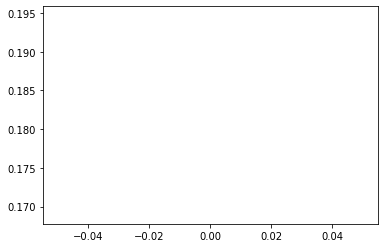

pruning network...
PRUNING ITERATION  3 Prune proportion: 0.34390000000000004 Sun Aug 23 12:08:57 2020
---------------------
PRUNING ITERATION  3 Sun Aug 23 12:08:57 2020
Begin Sun Aug 23 12:08:57 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/4.. Training Loss: 0.25557419283337884 Validation Loss: 0.19102995186755112 Sun Aug 23 12:19:19 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/4.. Training Loss: 0.22073029824951382 Validation Loss: 0.18220630754186803 Sun Aug 23 12:29:35 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/4.. Training Loss: 0.20921844970307835 Validation Loss: 0.17727365469206766 Sun Aug 23 12:39:53 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 4/4.. Training Loss: 0.20131248397765641 Validation Loss: 0.1738025477629733 Sun Aug 23 12:50:19 2020


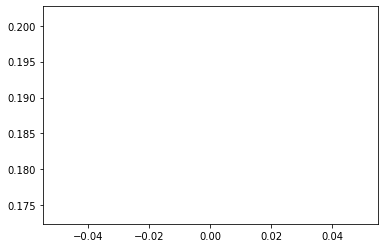

pruning network...
PRUNING ITERATION  4 Prune proportion: 0.40951000000000004 Sun Aug 23 12:50:19 2020
---------------------
PRUNING ITERATION  4 Sun Aug 23 12:50:19 2020
Begin Sun Aug 23 12:50:19 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/5.. Training Loss: 0.30627056000738023 Validation Loss: 0.21540239585788343 Sun Aug 23 13:00:39 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/5.. Training Loss: 0.24784342948711593 Validation Loss: 0.2000299322836358 Sun Aug 23 13:11:08 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/5.. Training Loss: 0.23079875700942845 Validation Loss: 0.18939575479076853 Sun Aug 23 13:21:31 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 4/5.. Training Loss: 0.21697070090586387 Validation Loss: 0.18467469414663984 Sun Aug 23 13:31:56 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch

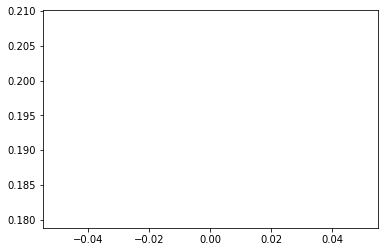

In [14]:
from torchvision import models
from collections import OrderedDict
from torch import optim

learning_rate=.0002

repetitions = 5
prune_proportion = 0.0
prune_change=lambda x:0.1+0.9*x #Keep 90% of the existing network
momentum = 0.5
network = models.resnet18(pretrained = True)

fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,104)),
    #('relu', nn.ReLU()),
    #('fc2', nn.Linear(100,104)),
    ('output', nn.LogSoftmax(dim=1))
]))

network.fc = fc

network.to(default_device)

initial_state_dict = torch.load('/content/gdrive/My Drive/flowers0822_e04.pth')
#init the masks, etc. 
network.load_state_dict(initial_state_dict)

prune_network(network, 0.0)
#saved_val = initial_state_dict["conv1.weight_orig"].clone().detach()
# delete all the masks so that they are not loaded later
for k in initial_state_dict.copy():
    # detach the vars so they don't just change as the model trains
    initial_state_dict[k] = initial_state_dict[k].clone().detach()
    if "mask" in k:
        del initial_state_dict[k]


#torch.save(network.state_dict(), './pruning_examples/model.pth') # save the initial model + weights to the disk but also keep in memory



for rep in range(repetitions):
    prune_proportion=prune_change(prune_proportion)
    j_epochs=3+int(rep/2) #increase the number of epochs by 1 every other time
    #load the original weights w/o changing the pruning mask
    network.load_state_dict(initial_state_dict, strict=False)
    # re-make the optimizer to make sure it's tracking the weight tensors properly
    optimizer = optim.SGD(network.parameters(), lr=learning_rate,momentum=momentum)

    print("PRUNING ITERATION ",rep, "Prune proportion:", prune_proportion, ctime())

    #load the original weights w/o changing the pruning mask
    network.load_state_dict(initial_state_dict, strict=False)
    # re-make the optimizer to make sure it's tracking the weight tensors properly
    optimizer = optim.SGD(network.parameters(), lr=learning_rate,momentum=momentum)

    print("---------------------\nPRUNING ITERATION ",rep, ctime())
    train_validate(network,TRAINING_FILENAMES, VALIDATION_FILENAMES, criterion, optimizer, j_epochs,
               t_transform=t_transform, v_transform=v_transform) 
    # train for J iterations
    # prune network
    if rep < repetitions-1: # if not the end of last round
        print("pruning network...")
        prune_network(network, prune_proportion)

    torch.save(network.state_dict(), '/content/gdrive/My Drive/flowers0823pruned3_{}.pth'.format(rep))

---------------------
PRUNING ITERATION  5 Sat Aug 22 14:08:30 2020
Begin Sat Aug 22 14:08:30 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.23563518310718645 Validation Loss: 0.18653470824536836 Sat Aug 22 14:18:45 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.21373171239476724 Validation Loss: 0.1772342482822594 Sat Aug 22 14:28:59 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.20296166954410316 Validation Loss: 0.17264850878012206 Sat Aug 22 14:39:18 2020


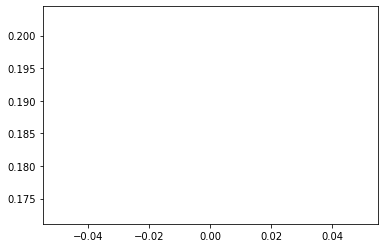

---------------------
PRUNING ITERATION  6 Sat Aug 22 14:39:18 2020
Begin Sat Aug 22 14:39:18 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.23459376479577693 Validation Loss: 0.18549463288970933 Sat Aug 22 14:49:41 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.21342659418039636 Validation Loss: 0.1800723378586679 Sat Aug 22 15:00:05 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.20390048907834726 Validation Loss: 0.17333450017834146 Sat Aug 22 15:10:30 2020


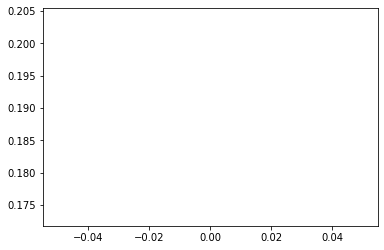

---------------------
PRUNING ITERATION  7 Sat Aug 22 15:10:30 2020
Begin Sat Aug 22 15:10:30 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.2356738170847971 Validation Loss: 0.18608280125571863 Sat Aug 22 15:20:55 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.2129146051922845 Validation Loss: 0.17747319268929804 Sat Aug 22 15:31:21 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.2031943696691019 Validation Loss: 0.1725847350698414 Sat Aug 22 15:41:49 2020


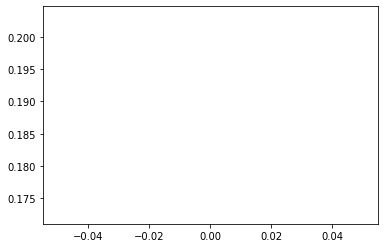

---------------------
PRUNING ITERATION  8 Sat Aug 22 15:41:50 2020
Begin Sat Aug 22 15:41:50 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.23296594312099778 Validation Loss: 0.18465576208887044 Sat Aug 22 15:52:15 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.2115148775864328 Validation Loss: 0.17771523913111667 Sat Aug 22 16:02:40 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.20307035519498512 Validation Loss: 0.17178385567064558 Sat Aug 22 16:13:07 2020


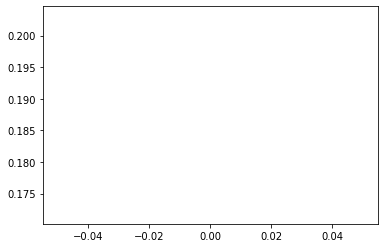

---------------------
PRUNING ITERATION  9 Sat Aug 22 16:13:08 2020
Begin Sat Aug 22 16:13:08 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.23475420089186028 Validation Loss: 0.18541076094923734 Sat Aug 22 16:23:41 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.21318336789639597 Validation Loss: 0.17768463988965055 Sat Aug 22 16:34:06 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.20367389992971957 Validation Loss: 0.17274037434253842 Sat Aug 22 16:44:15 2020


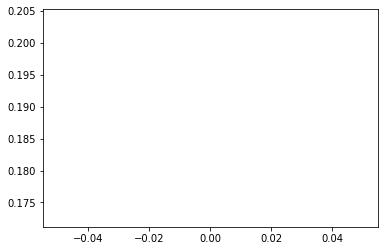

In [ ]:
prune_proportion = 0.2

for rep in range(5, 10):
    #load the original weights w/o changing the pruning mask
    network.load_state_dict(initial_state_dict, strict=False)
    # re-make the optimizer to make sure it's tracking the weight tensors properly
    optimizer = optim.SGD(network.parameters(), lr=learning_rate,momentum=momentum)

    print("---------------------\nPRUNING ITERATION ",rep, ctime())
    train_validate(network,TRAINING_FILENAMES, VALIDATION_FILENAMES, criterion, optimizer, j_epochs,
               t_transform=t_transform, v_transform=v_transform) 
    # train for J iterations
    # prune network
    if rep < repetitions-1: # if not the end of last round
        print("pruning network...")
        prune_network(network, prune_proportion)

    torch.save(network.state_dict(), '/content/gdrive/My Drive/flowers0822pruned_{}.pth'.format(rep))


In [ ]:
torch.save(network.state_dict(), '/content/gdrive/My Drive/flowers0822pruned.pth')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



PRUNING ITERATION  0 Prune proportion: 0.1 Sun Aug 23 05:55:24 2020
Begin Sun Aug 23 05:55:24 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.23849039363723676 Validation Loss: 0.18424877248592034 Sun Aug 23 06:05:43 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.21204154877291373 Validation Loss: 0.17831402636084961 Sun Aug 23 06:16:02 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.2054151752425448 Validation Loss: 0.1731126523528505 Sun Aug 23 06:26:19 2020


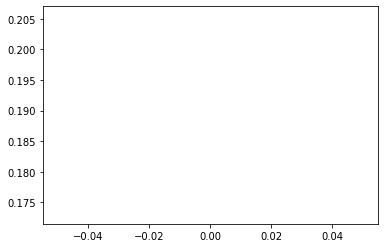

pruning network...


NameError: ignored

In [ ]:
from torchvision import models
from collections import OrderedDict
from torch import optim
learning_rate=.0002

repetitions = 10
prune_proportion = 0.0
prune_change=lambda x:0.1+0.9*x #Keep 90% of the existing network
momentum = 0.5

network2 = models.resnet18(pretrained = True)

fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,104)),
    #('relu', nn.ReLU()),
    #('fc2', nn.Linear(100,104)),
    ('output', nn.LogSoftmax(dim=1))
]))

network2.fc = fc

network2.to(default_device)
initial_state_dict = torch.load('/content/gdrive/My Drive/flowers0822_e{:02d}.pth'.format(3))
#init the masks, etc. 
network2.load_state_dict(initial_state_dict)
prune_network(network2, prune_proportion)
#saved_val = initial_state_dict["conv1.weight_orig"].clone().detach()
# delete all the masks so that they are not loaded later
for k in initial_state_dict.copy():
    # detach the vars so they don't just change as the model trains
    initial_state_dict[k] = initial_state_dict[k].clone().detach()
    if "mask" in k:
        del initial_state_dict[k]

#torch.save(network.state_dict(), './pruning_examples/model.pth') # save the initial model + weights to the disk but also keep in memory



for rep in range(repetitions):
    prune_proportion=prune_change(prune_proportion)
    j_epochs=3+int(rep/2) #increase the number of epochs by 1 every other time
    #load the original weights w/o changing the pruning mask
    network2.load_state_dict(initial_state_dict, strict=False)
    # re-make the optimizer to make sure it's tracking the weight tensors properly
    optimizer = optim.SGD(network2.parameters(), lr=learning_rate,momentum=momentum)

    print("PRUNING ITERATION ",rep, "Prune proportion:", prune_proportion, ctime())
    train_validate(network2,TRAINING_FILENAMES, VALIDATION_FILENAMES, criterion, optimizer, j_epochs,
               t_transform=t_transform, v_transform=v_transform) 
    # train for J iterations
    # prune network
    if rep < repetitions-1: # if not the end of last round
        print("pruning network...")
        prune_network(network2, prune_proportion)

    torch.save(network2.state_dict(), '/content/gdrive/My Drive/flowers0823pruned2_{}.pth'.format(rep))


PRUNING ITERATION  0 Prune proportion: 0.19 Sun Aug 23 06:54:53 2020
Begin Sun Aug 23 06:54:53 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.23399407583494275 Validation Loss: 0.18590949596194872 Sun Aug 23 07:05:09 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.21371861365830805 Validation Loss: 0.17728742916570528 Sun Aug 23 07:15:23 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.20241382213785986 Validation Loss: 0.1729358983234149 Sun Aug 23 07:25:40 2020


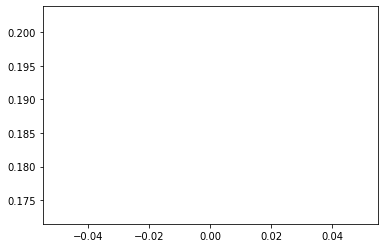

pruning network...
PRUNING ITERATION  1 Prune proportion: 0.271 Sun Aug 23 07:25:41 2020
Begin Sun Aug 23 07:25:41 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.24236116098589236 Validation Loss: 0.18948822334440873 Sun Aug 23 07:36:02 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.21648909287911475 Validation Loss: 0.1811656681017886 Sun Aug 23 07:46:31 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.20562127765361854 Validation Loss: 0.17526380068237155 Sun Aug 23 07:56:51 2020


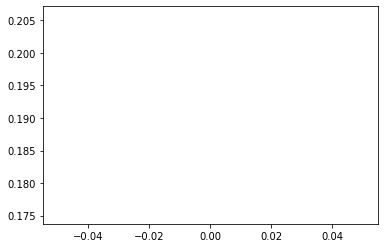

pruning network...
PRUNING ITERATION  2 Prune proportion: 0.34390000000000004 Sun Aug 23 07:56:51 2020
Begin Sun Aug 23 07:56:51 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/4.. Training Loss: 0.2569733509491689 Validation Loss: 0.1938060850290389 Sun Aug 23 08:07:10 2020


In [ ]:
for rep in range(repetitions):
    prune_proportion=prune_change(prune_proportion)
    j_epochs=3+int(rep/2) #increase the number of epochs by 1 every other time
    #load the original weights w/o changing the pruning mask
    network2.load_state_dict(initial_state_dict, strict=False)
    # re-make the optimizer to make sure it's tracking the weight tensors properly
    optimizer = optim.SGD(network2.parameters(), lr=learning_rate,momentum=momentum)

    print("PRUNING ITERATION ",rep, "Prune proportion:", prune_proportion, ctime())
    train_validate(network2,TRAINING_FILENAMES, VALIDATION_FILENAMES, criterion, optimizer, j_epochs,
               t_transform=t_transform, v_transform=v_transform) 
    # train for J iterations
    # prune network
    if rep < repetitions-1: # if not the end of last round
        print("pruning network...")
        prune_network(network2, prune_proportion)

    torch.save(network2.state_dict(), '/content/gdrive/My Drive/flowers0823pruned2_{}.pth'.format(rep))

In [16]:
from numpy import random

SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.
    
    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

def create_class_visualization(target_y, model, dtype, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    # Randomly initialize the image as a PyTorch Tensor, and make it requires gradient.
    img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype).requires_grad_()

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data.copy_(jitter(img.data, ox, oy))

        ########################################################################
        # TODO: Use the model to compute the gradient of the score for the     #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. Don't forget the #
        # L2 regularization term!                                              #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        scores = model(img) # shape [1,1000]
        
        # score = scores[:,target_y] - l2_reg * torch.norm(img)
        score = scores.squeeze()[target_y] - l2_reg * torch.norm(img)
        
        score.backward()
      
        # img.data += learning_rate * img.grad.data / torch.norm(img.grad.data)
        # img.grad.data.zero_()
        with torch.no_grad():
            img += learning_rate * img.grad / torch.norm(img.grad)
            img.grad.zero_()

        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        
        # Undo the random jitter
        img.data.copy_(jitter(img.data, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img.data[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img.data, sigma=0.5)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.data.clone().cpu()))
            class_name = CLASSES[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img.data.cpu())

In [18]:
from scipy.ndimage.filters import gaussian_filter1d

def preprocess(img, size=224):
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        transforms.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = transforms.Compose([
        transforms.Lambda(lambda x: x[0]),
        transforms.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        transforms.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        transforms.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        transforms.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

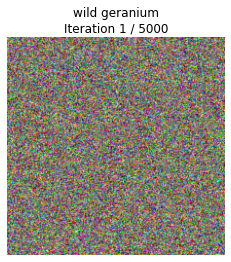

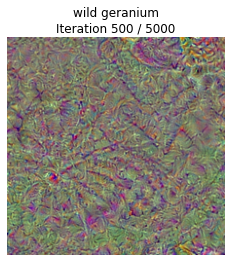

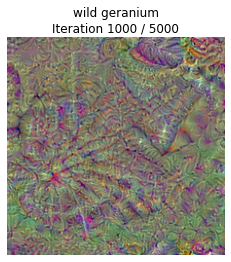

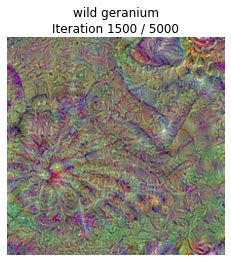

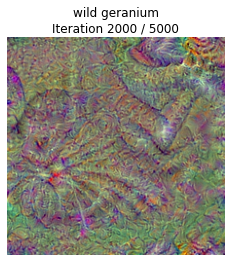

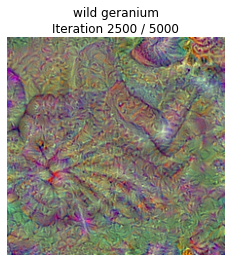

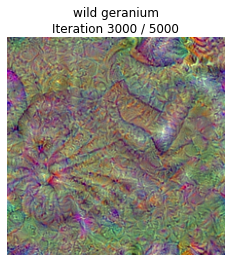

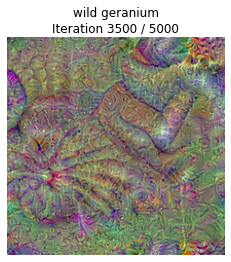

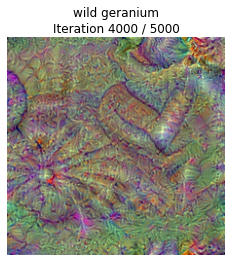

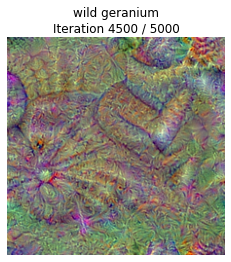

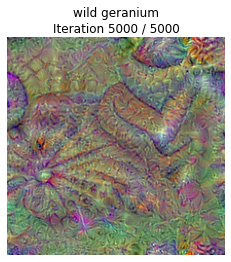

In [20]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor # Uncomment this to use GPU
network.type(dtype)

target_y = 4 
out = create_class_visualization(target_y, network, dtype, num_iterations=5000, show_every=500)

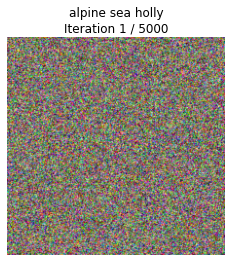

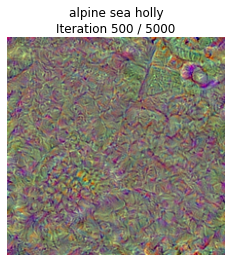

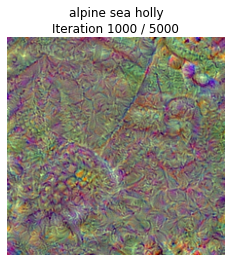

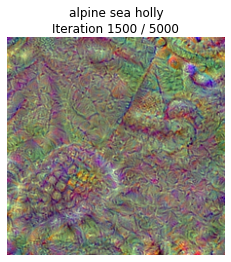

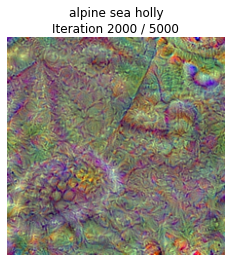

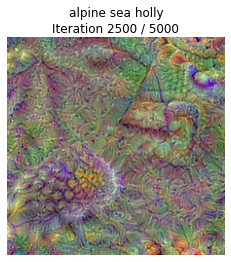

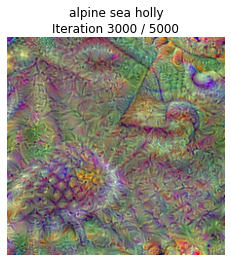

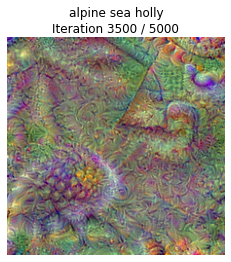

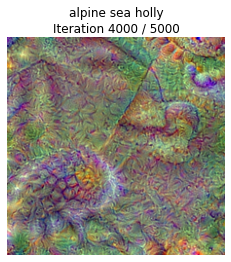

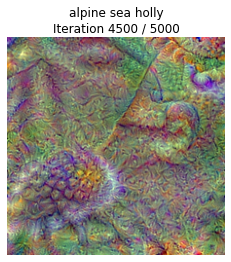

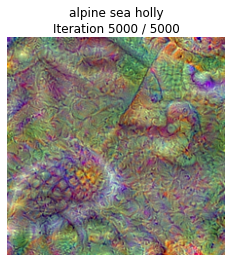

In [22]:
target_y = 34 
out = create_class_visualization(target_y, network, dtype, num_iterations=5000, show_every=500)

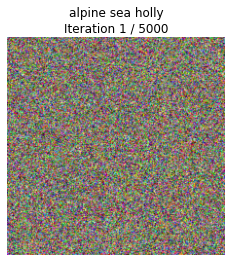

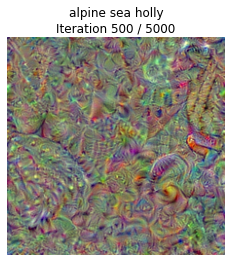

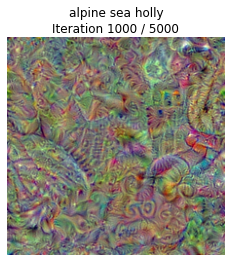

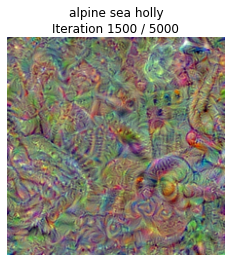

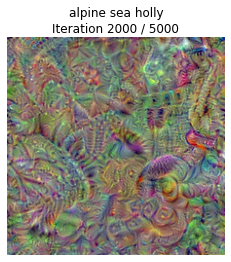

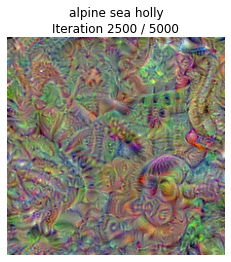

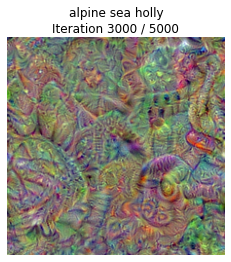

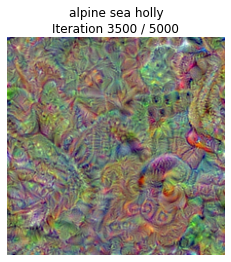

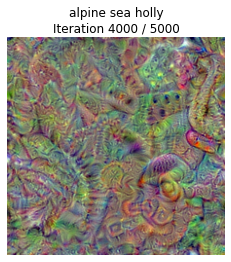

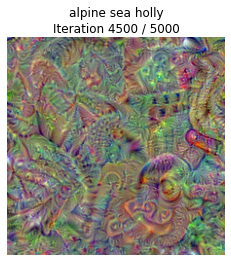

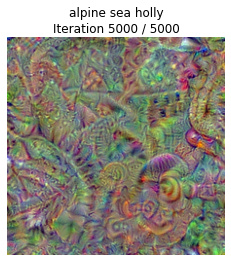

In [25]:
network2 = models.resnet18(pretrained = True)

fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,104)),
    #('relu', nn.ReLU()),
    #('fc2', nn.Linear(100,104)),
    ('output', nn.LogSoftmax(dim=1))
]))

network2.fc = fc

network2.to(default_device)
initial_state_dict = torch.load('/content/gdrive/My Drive/flowers0822_e{:02d}.pth'.format(5))
#init the masks, etc. 
network2.load_state_dict(initial_state_dict)

target_y = 34 
out = create_class_visualization(target_y, network2, dtype, num_iterations=5000, show_every=500)

In [ ]:
'''
val_loader = DataLoader(flower_val, batch_size = BATCH_SIZE, shuffle=False)
for s in range(NUM_VALIDATION_IMAGES//BATCH_SIZE):
    for images, labels in val_loader:
      inputs, labels = images.to(default_device), labels.to(default_device)
      inputs=inputs.permute(0,3,1,2)

      img = model(inputs)
      loss = criterion(img, labels)
      print(loss.item())
'''

In [ ]:
'''
flower_val = flowerDataSet(gcs_path=VALIDATION_FILENAMES, train = True)
flower_val_loader = DataLoader(flower_val, batch_size = 16, shuffle=False)
'''

In [ ]:
'''
def validate(model, trainloader, criterion, steps = 5):
    val_loss =[]
    for s in range(steps):
        running_loss =0
        for images, labels in trainloader:
            inputs, labels = images.to(default_device), labels.to(default_device)
            inputs=inputs.permute(0,3,1,2)

            optimizer.zero_grad()
            img = model(inputs)
            print(inputs.dtype, labels.dtype, img.dtype)
            print(inputs.shape, labels.shape, img.shape)

            loss = criterion(img, labels)
            running_loss+=loss
        print("Epoch : {}/{}..".format(s+1,steps),
         "Training Loss: {:.6f}".format(running_loss/len(trainloader))) 
        val_loss.append(running_loss)
    plt.plot(val_loss,label="Training Loss")
    plt.show() 
    '''